# tmp — jul24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

print(f"host: {os.uname().nodename}")

host: mach

## HIP-VAE

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')

cfg_vae['n_latents'] = 512 # [32, 64, 128, 256, 512]
cfg_vae['seq_len'] = 1

cfg_vae['norm_phi'] = False
cfg_vae['norm_proj'] = False
cfg_tr['epochs'] = 9000

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 'dec_type': 'lin', 
'enc_bias': False, 'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.05, 'seq_len': 1, 'norm_phi': False, 
'norm_proj': False}

Trainer:
{'lr': 0.005, 'batch_size': 1000, 'epochs': 9000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0}

In [4]:
from vae.vae import HIPVAE
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
tr.train()

epoch # 4784, avg loss: 165.317359:  53%|▌| 4784/9000 [6:44:54<4:34:47,  3.91s/iIOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'][:, -tr.model.cfg.n_latents[-1]:]
loss = {k: v.mean(0) for k, v in loss.items() if k != 'kl_diag'}

print(loss)

{
    'kl': array([32.967236], dtype=float32),
    'recon': array([136.15366], dtype=float32),
    'nelbo': array([169.12088], dtype=float32)
}

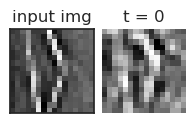

In [7]:
ncols = 1 + tr.model.cfg.seq_len
fig, axes = create_figure(1, ncols, (0.92 * ncols, 1.3), 'all', 'all')

ax = axes[0]
ax.imshow(data['x'][124].reshape(16, 16), cmap='Greys_r')
ax.set_title('input img')

for t in range(tr.model.cfg.seq_len):
    ax = axes[t + 1]
    ax.imshow(data['y'][124, t].reshape(16, 16), cmap='Greys_r')
    ax.set_title(f"t = {t}")
remove_ticks(axes[1:])
ax_square(axes);

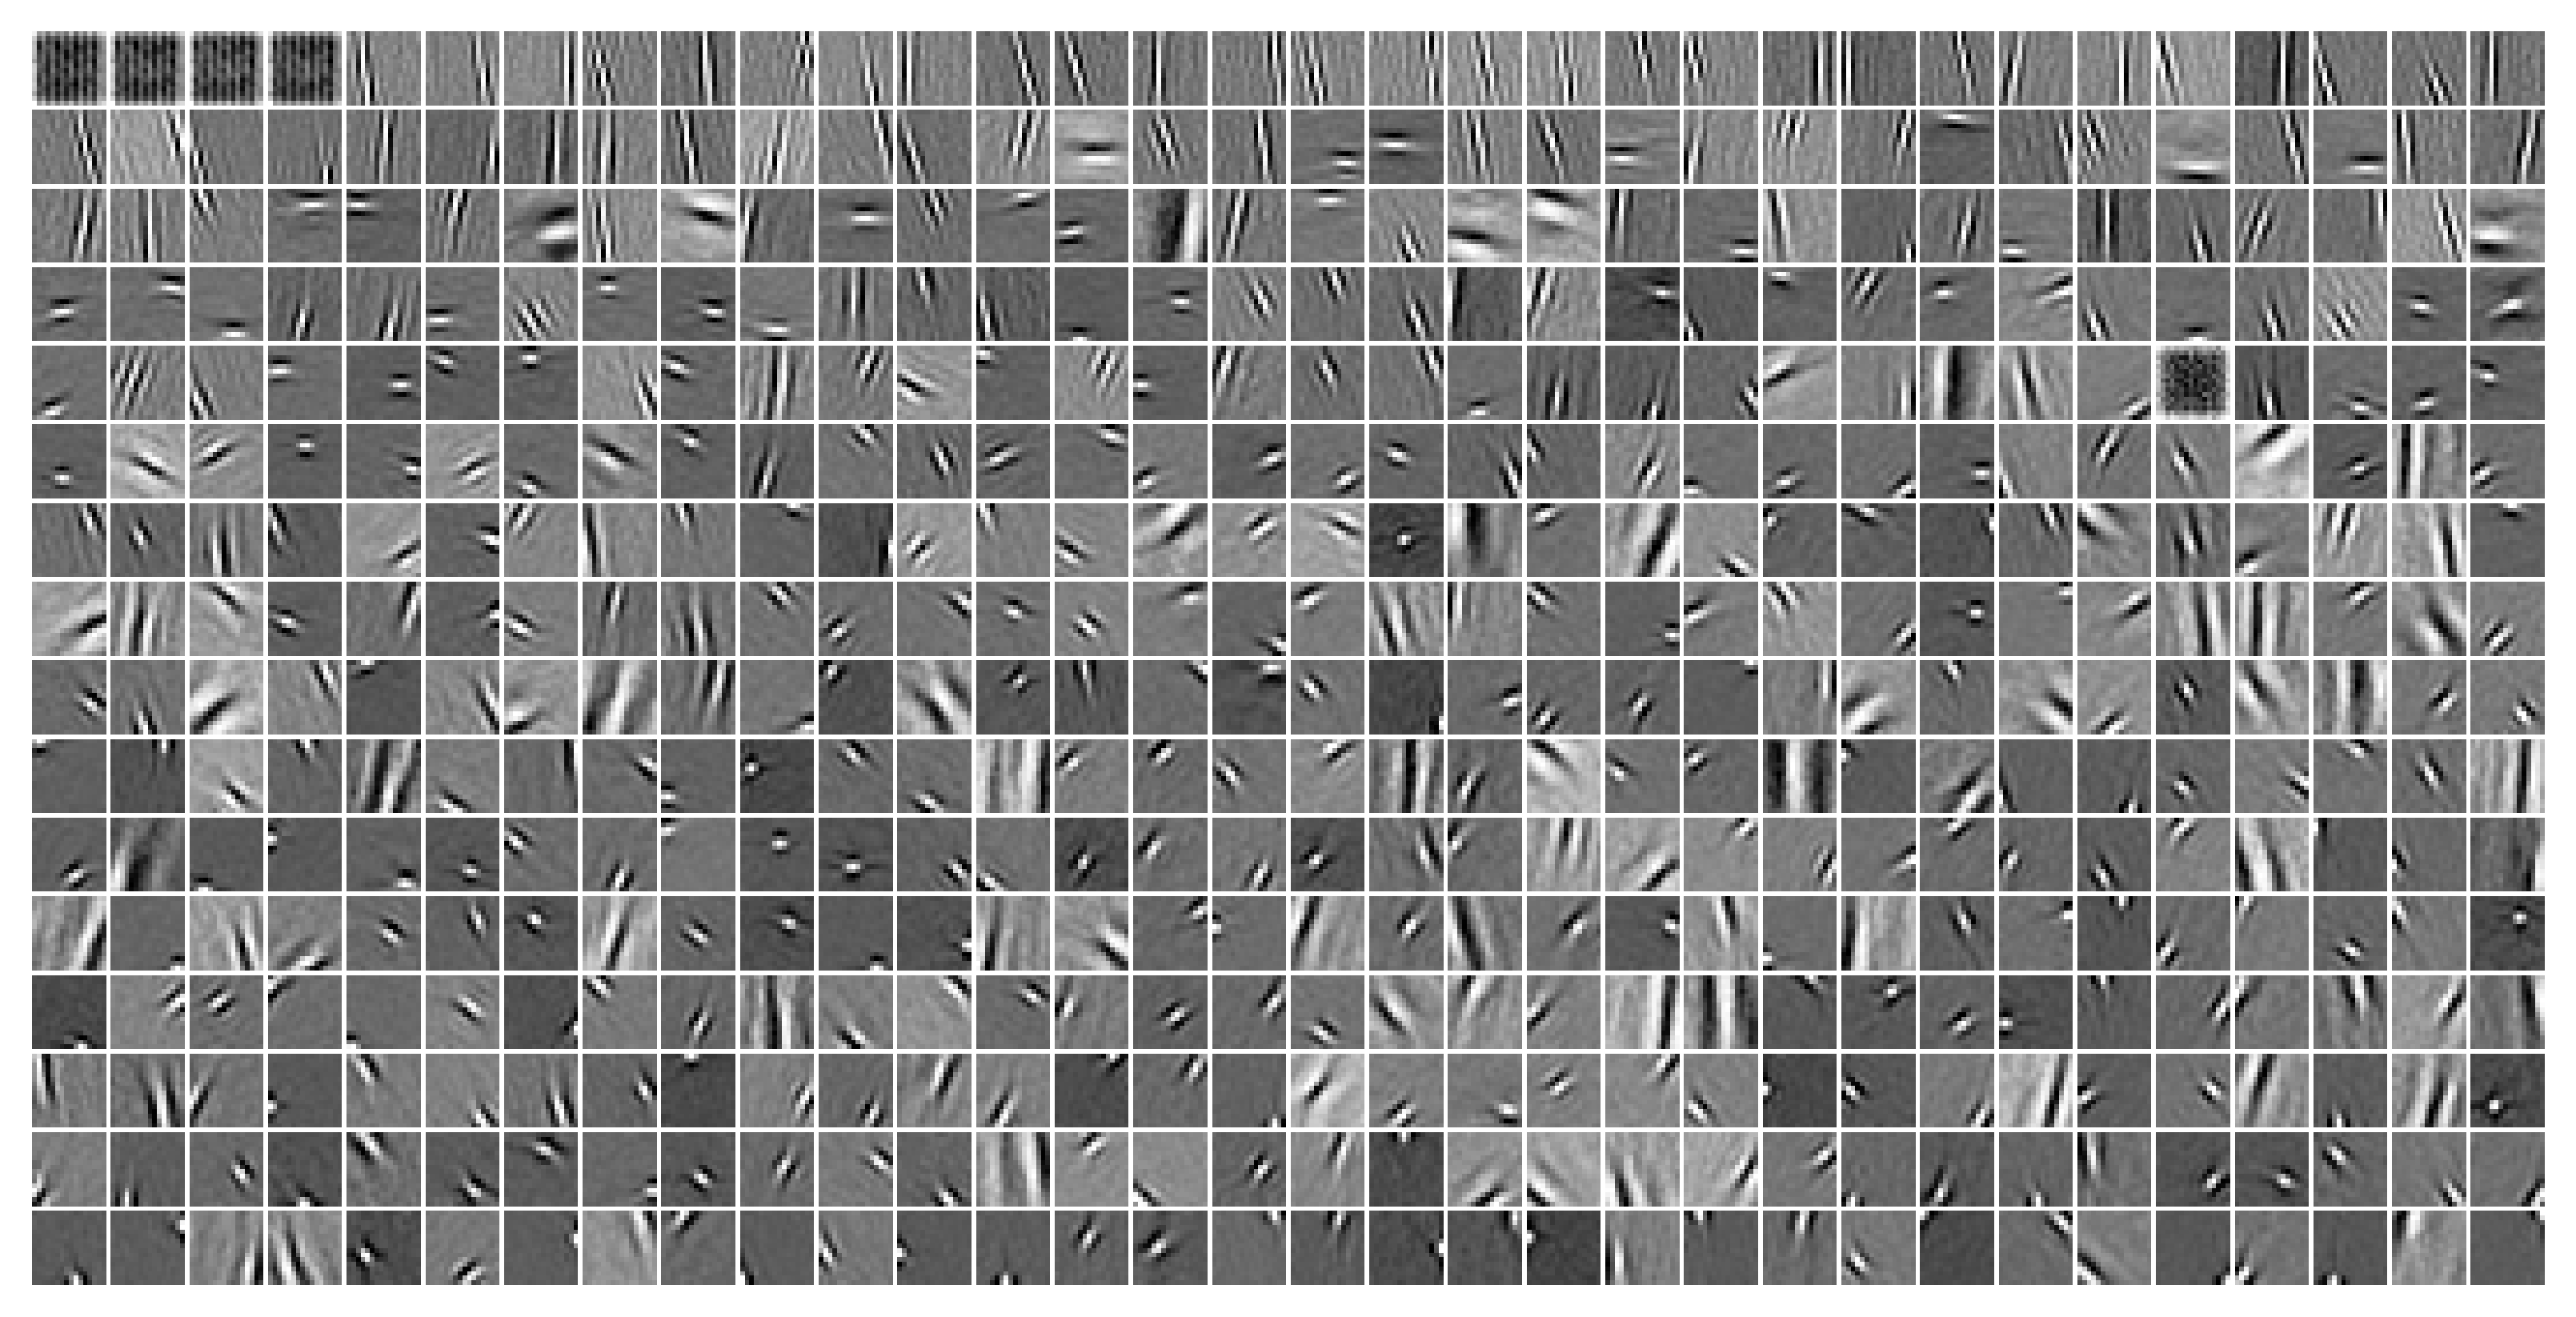

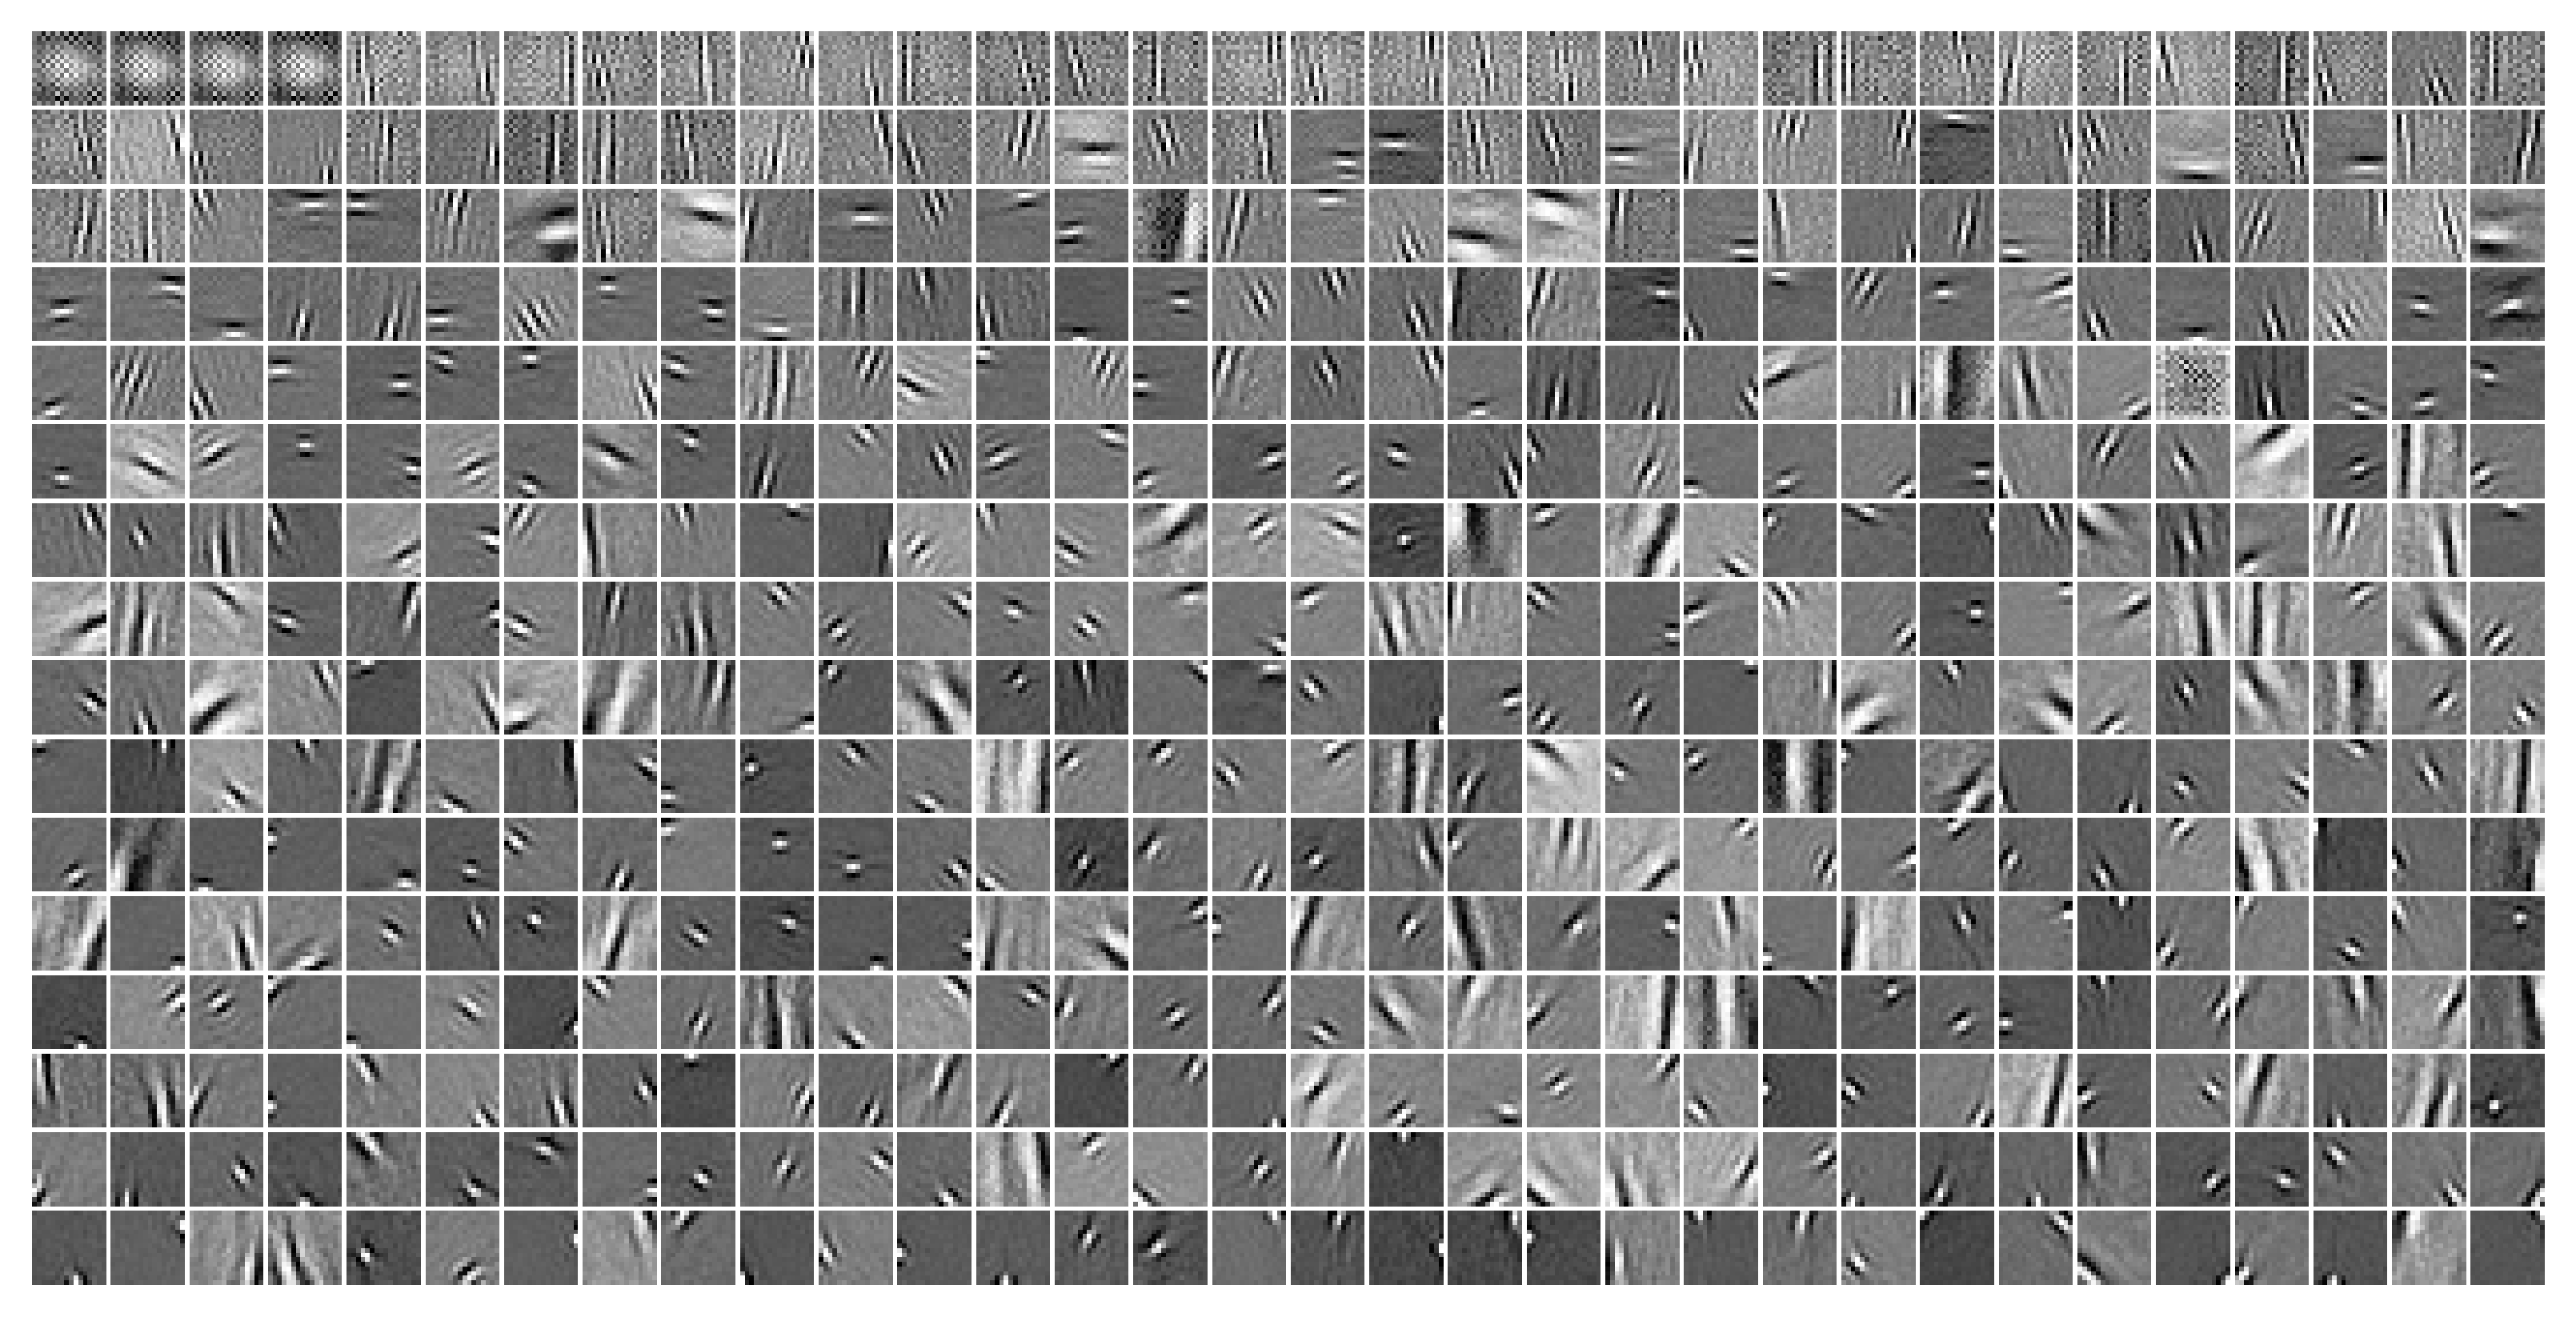

In [9]:
order = np.argsort(kl_diag[-1])
tr.model.show('phi', order=order, dpi=400)
tr.model.show('proj', order=order, dpi=400);

In [10]:
log_prior_rate = tr.model.input_layer.log_rate
log_prior_rate = tonp(log_prior_rate.squeeze())
log_prior_rate.shape

(512,)

In [12]:
thres = 2
dead = log_prior_rate > thres
dead.sum()

4

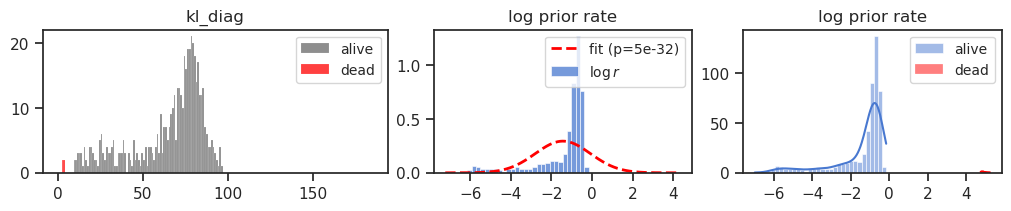

In [14]:
plot_kl_log_rates()

In [18]:
phi = tr.model.get_weight('phi').data
proj = tr.model.get_weight('proj').data
phi_norms = torch.linalg.vector_norm(phi, dim=0)
proj_norms = torch.linalg.vector_norm(proj, dim=0)

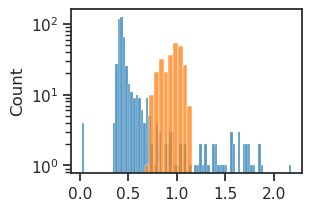

In [19]:
fig, ax = create_figure()
sns.histplot(tonp(phi_norms), color='C0')
sns.histplot(tonp(proj_norms), color='C1')
ax.set_yscale('log');

In [21]:
torch.linalg.matrix_rank(proj)

tensor(256, device='cuda:1')

In [23]:
results, _ = fit_loggabor(tr, verbose=True, add_kl=False)

100%|█████████████████████| 512/512 [00:26<00:00, 19.23it/s]


In [25]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan

In [26]:
u_test, t_test, cardinal_ratio = perform_test()
print(f"cardinal ratio: {cardinal_ratio:0.3g}\n\n{t_test}\n{u_test}")

cardinal ratio: 0.563

TtestResult(statistic=-10.118628229082328, pvalue=5.004783137442613e-22, df=502.0)
MannwhitneyuResult(statistic=18231.0, pvalue=1.0374043075011066e-15)

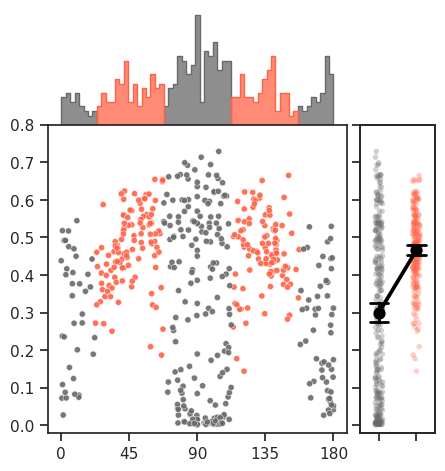

In [34]:
fig, _ = plot_theta(results, ylim_lower=-0.02, ylim_upper=0.8)

In [37]:
du_ff_norms = np.linalg.norm(etc['du_ff'], axis=-1)
du_ff_norms.shape

(25811, 1)

In [38]:
du_ff_norms.mean(0)

array([16.366657], dtype=float32)

In [5]:
x = next(iter(tr.dl_vld))[0]
vae.reset_states(len(x))
self = vae.input_layer

x.shape

torch.Size([1000, 256])

In [6]:
ff = self(x)[-1]
ff.shape

torch.Size([1000, 512])

In [7]:
ff = self(x, residual=False)[-1]
ff.shape

torch.Size([512])

In [8]:
dist, spks, pred = vae.input_layer.generate()
pred.shape

torch.Size([1000, 256])

In [9]:
proj = self.get_weight('proj')
proj.shape

torch.Size([512, 256])

In [10]:
du_ff = F.linear(x, proj)
du_ff.shape

torch.Size([1000, 512])

In [12]:
from base.distributions import softclamp_upper

In [13]:
du_ff = softclamp_upper(du_ff, 10)
du_ff.shape

torch.Size([1000, 512])

In [ ]:
	def ff_pass(self, residual):
		proj = self.get_weight('proj')
		du_ff = F.linear(residual, proj)
		du_ff = softclamp_upper(du_ff, 10)
		return du_ff

In [23]:
output = vae(x)
output_stacked = stack_all(output)

In [24]:
output_stacked['loss_kl'].shape, output_stacked['loss_recon'].shape

(torch.Size([1000, 1, 512]), torch.Size([1000, 1]))

In [25]:
output_stacked['ff'].shape

torch.Size([512, 1])

In [27]:
output['ff']['T_0']['L_0'].shape

torch.Size([512])

In [18]:
from dataclasses import dataclass
from vae.vae import _stack

In [19]:
@dataclass
class _FwdOutput:
	data: Dict[str, Union[torch.Tensor, dict]]

	def __getitem__(self, key):
		return self.data.get(key)

	def stack(self, item: str = None):
		output_stacked = {}
		if item is not None:
			return _stack(self[item])
		for k, v in self.data.items():
			try:
				output_stacked[k] = _stack(v)
			except TypeError:
				output_stacked[k] = v
		return output_stacked


def _stack(input_dict: Dict[str, Union[torch.Tensor, dict]]):
	# used for recon, loss_recon
	cond_tensor = all(
		isinstance(item, torch.Tensor)
		for item in input_dict.values()
	)
	if cond_tensor:  # output: [batch, seq_len]
		return torch.stack(list(input_dict.values()), dim=1)
	# used for ff, fb, loss_kl
	cond_dict = all(
		isinstance(item, dict) for
		item in input_dict.values()
	)
	if cond_dict:  # output: [batch, seq_len, tot # dims]
		stacked = []
		for k, v in input_dict.items():
			if not v:
				continue
			stacked.append(torch.cat(list(v.values()), dim=-1))
		if not stacked:  # whenever fb is empty (n_layers = 1)
			return
		return torch.stack(stacked, dim=1)
	return


In [20]:
output = _FwdOutput(data={
    'ff': {'T_0': {'L_0': torch.randn(123, 512), 'L_1': torch.randn(123, 512)}},
    'loss_recon': {'T_0': torch.randn(123)},
})

In [21]:
{k: v.shape for k, v in output.stack().items()}

{'ff': torch.Size([123, 1, 1024]), 'loss_recon': torch.Size([123, 1])}

In [22]:
output['ff']

{'T_0': {'L_0': tensor([[-0.8763,  0.6693,  0.3544,  ...,  0.8753,  0.4302,  0.8837],
          [ 1.3028, -1.6655,  0.1361,  ...,  0.2716, -1.8138, -1.7125],
          [ 0.1076,  0.3265, -0.3871,  ..., -2.2180, -0.6037,  0.5496],
          ...,
          [ 1.2719, -1.0087, -0.5100,  ...,  1.4481, -1.3208,  0.2569],
          [ 0.2911,  0.1427,  0.8463,  ..., -1.0155, -0.1530,  0.8134],
          [-1.0808, -0.9450, -0.5455,  ...,  0.0365, -1.2827, -1.7278]]),
  'L_1': tensor([[ 0.5745,  1.4883,  1.4690,  ...,  0.4998,  1.1756, -0.1843],
          [ 1.6836, -0.7224, -0.1505,  ...,  0.9159,  0.4525, -0.4935],
          [-0.4265, -0.8223, -0.3465,  ...,  0.3289,  0.8474,  1.2403],
          ...,
          [ 0.3027, -1.5540, -1.5029,  ...,  2.1270,  0.3454,  0.7119],
          [-0.9394, -0.2997, -0.9128,  ..., -1.2032, -0.9645, -0.3147],
          [-1.2670,  1.2779, -0.3483,  ..., -0.8796, -1.9831, -0.8673]])}}

In [23]:
output.data

{'ff': {'T_0': {'L_0': tensor([[-0.8763,  0.6693,  0.3544,  ...,  0.8753,  0.4302,  0.8837],
           [ 1.3028, -1.6655,  0.1361,  ...,  0.2716, -1.8138, -1.7125],
           [ 0.1076,  0.3265, -0.3871,  ..., -2.2180, -0.6037,  0.5496],
           ...,
           [ 1.2719, -1.0087, -0.5100,  ...,  1.4481, -1.3208,  0.2569],
           [ 0.2911,  0.1427,  0.8463,  ..., -1.0155, -0.1530,  0.8134],
           [-1.0808, -0.9450, -0.5455,  ...,  0.0365, -1.2827, -1.7278]]),
   'L_1': tensor([[ 0.5745,  1.4883,  1.4690,  ...,  0.4998,  1.1756, -0.1843],
           [ 1.6836, -0.7224, -0.1505,  ...,  0.9159,  0.4525, -0.4935],
           [-0.4265, -0.8223, -0.3465,  ...,  0.3289,  0.8474,  1.2403],
           ...,
           [ 0.3027, -1.5540, -1.5029,  ...,  2.1270,  0.3454,  0.7119],
           [-0.9394, -0.2997, -0.9128,  ..., -1.2032, -0.9645, -0.3147],
           [-1.2670,  1.2779, -0.3483,  ..., -0.8796, -1.9831, -0.8673]])}},
 'loss_recon': {'T_0': tensor([-0.2452, -1.2368, -1.4520,  

In [28]:
@dataclass
class _FwdOutput:
	dist: Any = None
	spks: torch.Tensor = None
	du_ff: torch.Tensor = None

In [29]:
aaa = _FwdOutput(du_ff=5)
aaa

_FwdOutput(dist=None, spks=None, du_ff=5)

In [31]:
aaa.du_ff

5

In [5]:
tr.train()

epoch # 900, avg loss: 164.066398: 100%|██████| 900/900 [43:18<00:00,  2.89s/it]


epoch # 900, avg loss: 124.197108: 100%|████| 900/900 [2:07:48<00:00,  8.52s/it]


In [6]:
data, loss, etc = tr.forward('vld', temp=0.0, full_data=True)

kl_diag = np.mean(loss['kl_diag'], axis=0)
kl_diag = kl_diag[-tr.model.cfg.n_latents[-1]:]
order = np.argsort(kl_diag.ravel())

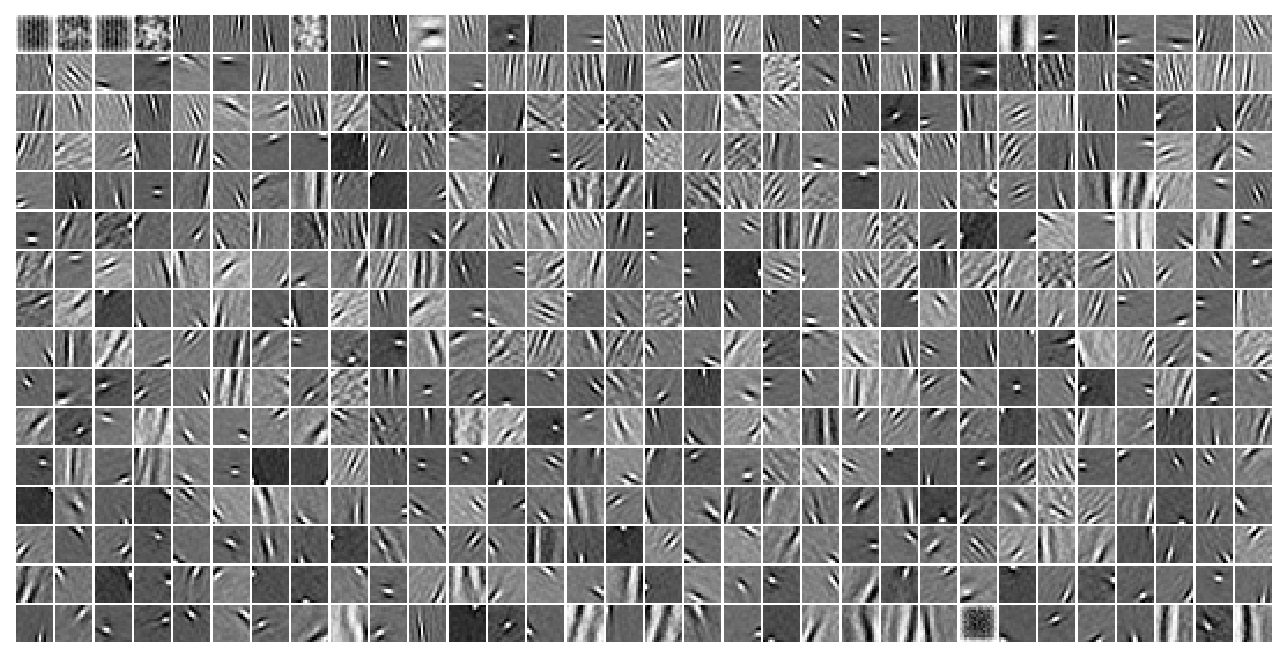

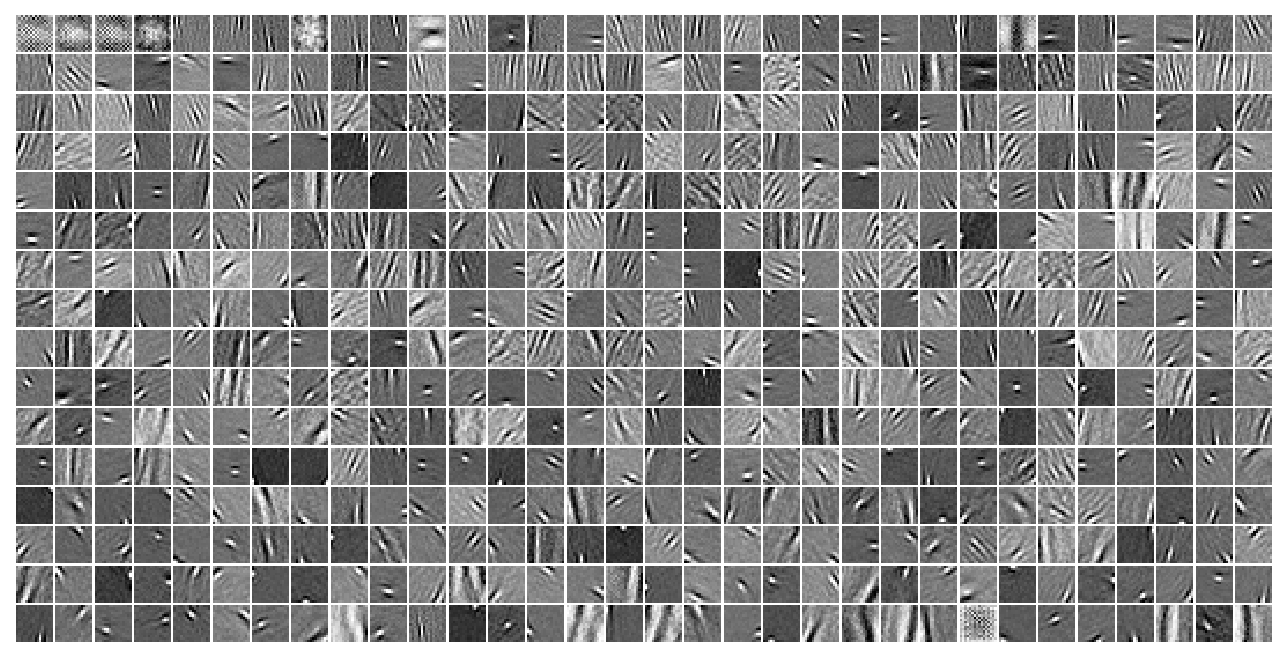

In [12]:
vae.show('phi', order=np.argsort(kl_diag))
vae.show('proj', order=np.argsort(kl_diag));

In [19]:
w = tonp(vae.get_weight('phi').grad).T

In [20]:
from figures.imgs import plot_weights

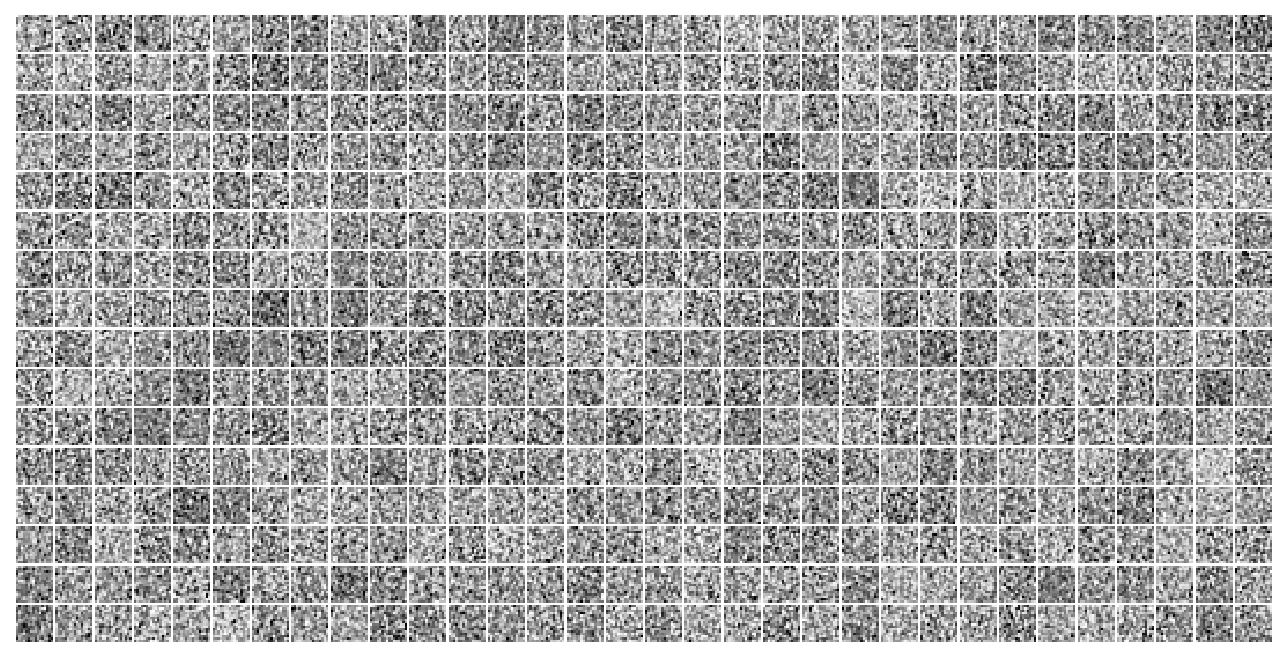

In [25]:
plot_weights(w.reshape(-1, 16, 16));

In [23]:
w.shape

(512, 256)

In [26]:
spks_final = data['z'][:, -1, :]
spks_final.shape

(25811, 512)

In [29]:
sparse_score(spks_final)[0].mean(), sparse_score(spks_final)[1].mean()

(0.7797122, 0.9587146)

In [16]:
spks_final

array([[0., 0., 0., ..., 1., 2., 1.],
       [0., 0., 0., ..., 1., 1., 3.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 2., 1.],
       [0., 0., 0., ..., 1., 0., 7.],
       [0., 0., 0., ..., 0., 4., 2.]], dtype=float32)

In [18]:
input_layer = list(vae.layers.values())[-1]
phi = input_layer.get_weight('phi')
phi_norms = torch.linalg.vector_norm(phi, dim=0)

<Axes: ylabel='Count'>

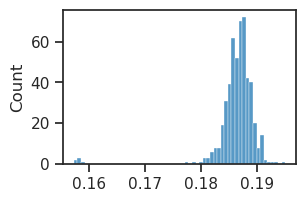

In [19]:
sns.histplot(tonp(phi_norms))

In [20]:
list(etc)

['du_ff', 'du_fb']

In [23]:
etc['du_fb'].shape

(25811, 3, 960)

In [35]:
t = 2
np.quantile(etc['du_fb'][:, t, :], 0.03), np.quantile(etc['du_fb'][:, t, :], 0.97)

(-0.0847594365477562, 0.0)

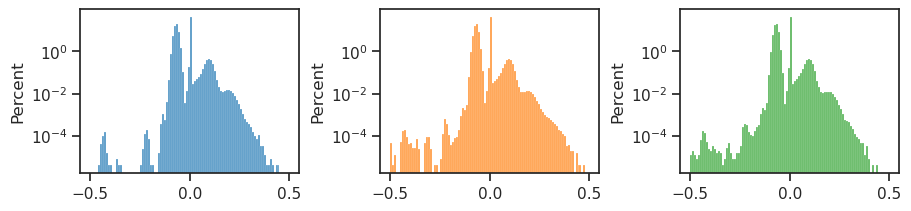

In [40]:
fig, axes = create_figure(1, 3)

for t, ax in enumerate(axes.flat):
    sns.histplot(
        etc['du_fb'][:, t, :].ravel(),
        bins=np.linspace(-0.5, 0.5, 101),
        stat='percent',
        color=f'C{t}',
        ax=ax,
    )
    ax.set_yscale('log')
plt.show()

In [41]:
np.mean(etc['du_ff'], axis=(0, 2))

array([-0.02922124, -0.02936971, -0.02964353], dtype=float32)

In [5]:
%%time

data, loss, etc = tr.forward('vld', temp=0, full_data=True)

CPU times: user 2.67 s, sys: 299 ms, total: 2.97 s
Wall time: 2.97 s


In [6]:
list(data)

['x', 'y', 'z', 'g']

In [7]:
print({
    k: v.shape if len(v) else v
    for k, v in data.items()
})

{'x': (25811, 3, 256), 'y': (25811, 3, 256), 'z': (25811, 3, 992), 'g': []}

In [8]:
print({
    k: v.shape if len(v) else v
    for k, v in loss.items()
})

{'kl': (25811, 3), 'kl_diag': (3, 992), 'recon': (25811, 3), 'nelbo': (25811, 3)}

In [9]:
from vae.train_vae import _prep

In [10]:
loss_avg = {
    k: _prep(v) for k, v in
    loss.items() if k != 'kl_diag'
}
to_write = {}
for name, val_dict in loss_avg.items():
    for t, v in val_dict.items():
        to_write[f"eval/name_T={t}"] = v

In [11]:
to_write

{'eval/name_T=0': 200.66037,
 'eval/name_T=1': 221.8464,
 'eval/name_T=2': 52652.742,
 'eval/name_T=sum': 53075.248962402344}

In [13]:
data['z'].shape

(25811, 3, 992)

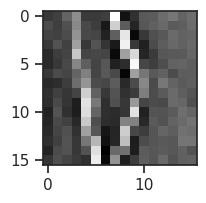

In [45]:
plt.imshow(data['x'][124, 2].reshape(16, 16), cmap='Greys_r')

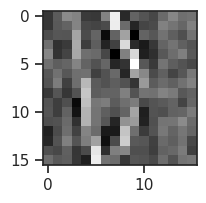

In [53]:
plt.imshow(data['y'][124, 2].reshape(16, 16), cmap='Greys_r')

In [47]:
data['y']

(25811, 3, 256)

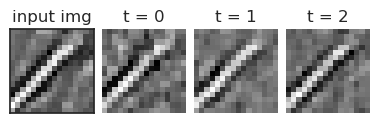

In [84]:
ncols = 1 + tr.model.cfg.seq_len
fig, axes = create_figure(1, ncols, (0.92 * ncols, 1.3), 'all', 'all')

img_i = 13857

ax = axes[0]
ax.imshow(data['x'][img_i, 0].reshape(16, 16), cmap='Greys_r')
ax.set_title('input img')

for t in range(tr.model.cfg.seq_len):
    ax = axes[t + 1]
    ax.imshow(data['y'][img_i, t].reshape(16, 16), cmap='Greys_r')
    ax.set_title(f"t = {t}")
remove_ticks(axes[1:])
ax_square(axes);

In [78]:
order_contrast = np.argsort(data['x'][:, 0, :].var(axis=-1))
order_contrast = order_contrast[::-1]
order_contrast[:10]

array([21601, 14945, 22005, 15450, 20528, 20018, 13857, 19408, 12800,
       17910])

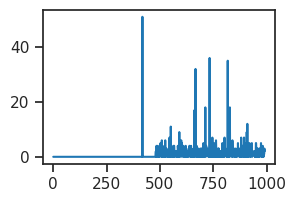

In [109]:
plt.plot(data['z'][img_i][2])

In [112]:
for k, layer in vae.layers.items():
    print(k, layer.log_rate.exp().mean())

L_0 tensor(0.0008, device='cuda:1', grad_fn=<MeanBackward0>)

L_1 tensor(0.0004, device='cuda:1', grad_fn=<MeanBackward0>)

L_2 tensor(0.0008, device='cuda:1', grad_fn=<MeanBackward0>)

L_3 tensor(0.2990, device='cuda:1', grad_fn=<MeanBackward0>)

L_4 tensor(1.6147, device='cuda:1', grad_fn=<MeanBackward0>)

In [5]:
x = torch.randn(123, 1, 256).to(device)
x = x.expand(-1, vae.cfg.seq_len, -1)
x.shape

torch.Size([123, 1, 256])

In [6]:
output = vae.xtract_ftr(x)
list(output)

['recon', 'dist', 'spks', 'ff', 'fb', 'loss_kl', 'loss_recon']

In [7]:
output

{'recon': {'T_0': tensor([[-0.2341, -0.1935,  0.1137,  ...,  0.1271, -0.0093, -0.0361],
          [-0.2452, -0.1462, -0.0870,  ..., -0.0054, -0.1484, -0.0926],
          [-0.0457, -0.1541,  0.0471,  ..., -0.1732, -0.0142, -0.1466],
          ...,
          [-0.0139,  0.0318,  0.0907,  ..., -0.2659,  0.0168, -0.0995],
          [ 0.0177,  0.1031,  0.0104,  ...,  0.0302, -0.0512, -0.0419],
          [-0.0562, -0.2938,  0.1792,  ..., -0.0447, -0.5222,  0.1991]],
         device='cuda:1')},
 'dist': {'T_0': {'L_0': <base.distributions.Poisson at 0x7f4970c3dd10>}},
 'spks': {'T_0': {'L_0': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 1., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1')}},
 'ff': {'T_0': {'L_0': tensor([ 1.1855, -0.0600, -0.1962,  0.6454,  0.3118,  1.7510,  0.2978,  0.4105,
           -1

In [11]:
dist, spks, ff, fb, recon, loss_kl, loss_recon = vae.xtract_ftr(x)
spks, ff, fb, recon, loss_kl, loss_recon = map(
    stack_tz, [spks, ff, fb, recon, loss_kl, loss_recon])

# ff.shape, fb, recon.shape, loss_kl.shape, loss_recon.shape
spks.shape, ff.shape, fb.shape, recon.shape, loss_kl.shape, loss_recon.shape

(torch.Size([123, 3, 992]),
 torch.Size([123, 3, 992]),
 torch.Size([123, 3, 960]),
 torch.Size([123, 3, 256]),
 torch.Size([123, 3, 992]),
 torch.Size([123, 3]))

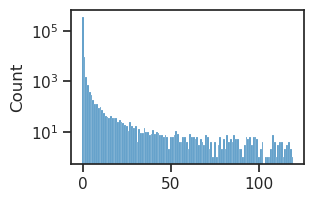

In [20]:
ax = sns.histplot(tonp(spks.ravel()).astype(int), bins=np.linspace(0, 120, 121) - 0.5)
ax.set_yscale('log')

In [7]:
dist, ff, fb, recon, loss_kl, loss_recon = vae.xtract_ftr(x)

In [11]:
recon['T_2'].shape

torch.Size([123, 256])

In [5]:
print(vae)
vae.print()

HIPVAE(
  (mse): MSELoss()
  (layers): ModuleDict(
    (L_0): PoissonLayer(dim=32, input_dim=64, temp=1, n_exp=263)
    (L_1): PoissonLayer(dim=64, input_dim=128, temp=1, n_exp=263)
    (L_2): PoissonLayer(dim=128, input_dim=256, temp=1, n_exp=263)
    (L_3): PoissonLayer(dim=256, input_dim=512, temp=1, n_exp=263)
    (L_4): PoissonLayer(dim=512, input_dim=256, temp=1, n_exp=263)
  )
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  611.3 K   |
|     ———     |    ———     |
|  layers.L_0 |   4.1 K    |
|  layers.L_1 |   16.4 K   |
|  layers.L_2 |   65.7 K   |
|  layers.L_3 |  262.4 K   |
|  layers.L_4 |  262.7 K   |
+-------------+------------+

In [6]:
x = torch.randn(123, 1, 256).to(device)
x = x.expand(-1, vae.cfg.seq_len, -1)
x.shape

torch.Size([123, 1, 256])

In [8]:
dist, ff, fb, kl, recon = vae(x)
dist, ff, fb, kl, recon = vae.xtract_ftr(x)

(torch.Size([123, 1, 512]), torch.Size([123, 1]))

In [11]:
list(fb)

['T_0']

In [11]:
dist

{'T_0': {'L_0': <base.distributions.Poisson at 0x7fad52a39650>,
  'L_1': <base.distributions.Poisson at 0x7fad60d852d0>,
  'L_2': <base.distributions.Poisson at 0x7fad3020f2d0>,
  'L_3': <base.distributions.Poisson at 0x7fad3020fb50>,
  'L_4': <base.distributions.Poisson at 0x7fad2426fe10>},
 'T_1': {'L_0': <base.distributions.Poisson at 0x7fad10bea610>,
  'L_1': <base.distributions.Poisson at 0x7fad2426fed0>,
  'L_2': <base.distributions.Poisson at 0x7fad10ab6fd0>,
  'L_3': <base.distributions.Poisson at 0x7fad10ab6710>,
  'L_4': <base.distributions.Poisson at 0x7fad10ab7c90>},
 'T_2': {'L_0': <base.distributions.Poisson at 0x7fad3020c110>,
  'L_1': <base.distributions.Poisson at 0x7fad10ab6d50>,
  'L_2': <base.distributions.Poisson at 0x7fad54264950>,
  'L_3': <base.distributions.Poisson at 0x7fad3020de10>,
  'L_4': <base.distributions.Poisson at 0x7fad10ab70d0>}}

In [33]:
i, (x, *_) = next(enumerate(tr.dl_trn))
x.shape

torch.Size([1000, 1, 16, 16])

In [40]:

x.shape

torch.Size([1000, 3, 768])

In [17]:
next(list(tr.model.layers.values()))

TypeError: 'list' object is not an iterator

1.0

In [34]:
invert_dict(dist)

{'L_0': {'T_0': <base.distributions.Poisson at 0x7f9103ecde10>,
  'T_1': <base.distributions.Poisson at 0x7f90033ef690>,
  'T_2': <base.distributions.Poisson at 0x7f901037c1d0>},
 'L_1': {'T_0': <base.distributions.Poisson at 0x7f9001bed210>,
  'T_1': <base.distributions.Poisson at 0x7f9001bfcc50>,
  'T_2': <base.distributions.Poisson at 0x7f9001bfe150>},
 'L_2': {'T_0': <base.distributions.Poisson at 0x7f9001bef290>,
  'T_1': <base.distributions.Poisson at 0x7f9001bfdf50>,
  'T_2': <base.distributions.Poisson at 0x7f9001bfe890>},
 'L_3': {'T_0': <base.distributions.Poisson at 0x7f9001bfd990>,
  'T_1': <base.distributions.Poisson at 0x7f9001bcd550>,
  'T_2': <base.distributions.Poisson at 0x7f9001bfea10>},
 'L_4': {'T_0': <base.distributions.Poisson at 0x7f9001bfcd90>,
  'T_1': <base.distributions.Poisson at 0x7f9001bce6d0>,
  'T_2': <base.distributions.Poisson at 0x7f9001bfead0>}}

In [36]:
dist, kl, recon_batch = tr._fun(x)
kl.shape, recon_batch.shape

(torch.Size([123, 3, 992]), torch.Size([123, 3]))

In [8]:
kl_batch = torch.sum(kl, dim=2)
kl_diag = torch.mean(kl, dim=0)

kl_batch.shape, kl_diag.shape

(torch.Size([123, 3]), torch.Size([3, 512]))

In [9]:
loss_batch = recon_batch + 1 * kl_batch
loss = torch.mean(loss_batch, dim=0)

loss_batch.shape, loss.shape

(torch.Size([123, 3]), torch.Size([3]))

In [10]:
loss

tensor([260.3076, 275.3791, 889.3961], device='cuda:1',
       grad_fn=<MeanBackward1>)

In [14]:
torch.mean(kl_batch, dim=0), torch.mean(recon_batch, dim=0)

(tensor([ 1.9726,  8.9847, 69.1697], device='cuda:1', grad_fn=<MeanBackward1>),
 tensor([258.3350, 266.3943, 820.2264], device='cuda:1',
        grad_fn=<MeanBackward1>))

In [20]:
_nelbo = recon_batch + kl_batch
_nelbo = torch.mean(_nelbo, dim=0)
_nelbo = tonp(_nelbo)
_nelbo = {
    t: v for t, v in
    enumerate(_nelbo)
}
_nelbo[-1] = sum(_nelbo.values())

In [21]:
_nelbo

{0: 260.3076, 1: 275.3791, 2: 889.39606, -1: 1425.0827331542969}

In [22]:
xxx = [32, 128, 512]
n_latents = xxx[::-1]
n_latents

[512, 128, 32]

In [7]:
dist

{'T_0': {'L_0': <base.distributions.Poisson at 0x7f54f190f050>},
 'T_1': {'L_0': <base.distributions.Poisson at 0x7f54e6ebf590>},
 'T_2': {'L_0': <base.distributions.Poisson at 0x7f54e6a9dbd0>}}

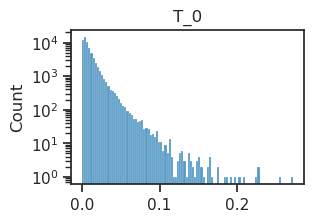

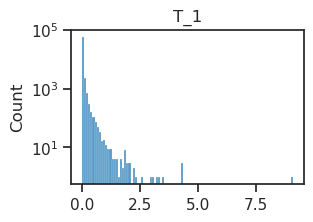

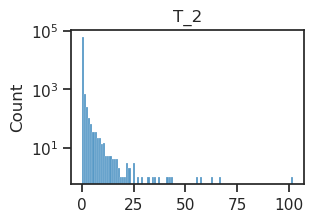

In [8]:
for k, v in dist.items():
    x2p = tonp(v['L_0'].rate).ravel()
    bins = np.linspace(0, x2p.max(), 101)
    ax = sns.histplot(x2p, bins=bins)
    ax.set(title=k, yscale='log')
    plt.show()

In [9]:
list(recon)

['T_0', 'T_1', 'T_2']

In [11]:
recon['T_0']

torch.Size([123])

In [16]:
torch.stack(list(recon.values())).shape

torch.Size([3, 123])

In [17]:
list(kl)

['T_0', 'T_1', 'T_2']

In [18]:
kl['T_0']

{'L_0': tensor([[3.2177e-04, 1.1301e-07, 9.7319e-03,  ..., 7.8317e-05, 6.4577e-03,
          3.2783e-03],
         [8.0615e-03, 2.4404e-02, 1.3646e-02,  ..., 5.7470e-05, 6.6671e-04,
          1.5137e-03],
         [6.6611e-03, 6.2678e-03, 5.2999e-04,  ..., 3.1793e-04, 6.1514e-03,
          1.6879e-03],
         ...,
         [2.1673e-03, 2.4140e-03, 4.1360e-04,  ..., 1.3001e-04, 3.3422e-05,
          2.3034e-07],
         [3.2775e-03, 1.1811e-03, 1.2904e-02,  ..., 2.3333e-03, 5.4145e-03,
          4.5434e-03],
         [2.0806e-02, 8.7904e-06, 6.9544e-05,  ..., 5.4869e-04, 5.4861e-03,
          5.7553e-03]], device='cuda:1', grad_fn=<MulBackward0>)}

In [26]:
kl_all = []
for k, v in kl.items():
    kl_all.append(torch.stack(
        list(v.values()), dim=1))
kl_all = torch.stack(kl_all, dim=1)
kl_all.shape

torch.Size([123, 3, 1, 512])

In [25]:
torch.stack(list(v.values()), dim=1).shape

torch.Size([123, 1, 512])

In [29]:

recon_all.shape

torch.Size([123, 3])

In [27]:
kl_all = []
for k, v in kl.items():
    kl_all.append(torch.cat(
        list(v.values()), dim=-1))
kl_all = torch.stack(kl_all, dim=1)
kl_all.shape

torch.Size([123, 3, 512])

In [6]:
layer = vae.layers['L_0']
print(layer)

PoissonLayer(dim=512, input_dim=256, temp=1, n_exp=263)

In [7]:
phi = layer.get_weight('phi')
torch.linalg.vector_norm(phi, dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

## P-VAE

In [9]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')
cfg_vae['enc_norm'] = True
cfg_vae['dec_norm'] = True
cfg_tr['epochs'] = 900

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_ch': 32, 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 
'dec_type': 'lin', 'enc_bias': False, 'dec_bias': False, 'init_dist': 'Normal', 'init_scale': 0.05, 'enc_norm': 
True, 'dec_norm': True}

Trainer:
{'lr': 0.005, 'batch_size': 1000, 'epochs': 900, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_z-512_fp_nrm-enc-dec_<lin|lin>
mc_b1000-ep900-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_07_25,17:31)

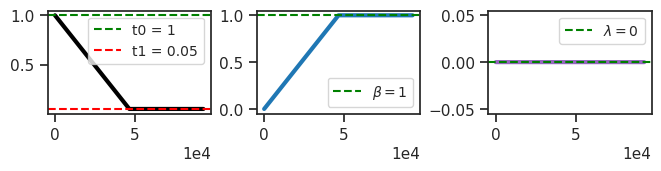

In [10]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
comment = (
    'nrm-enc-dec' if vae.cfg.enc_norm and vae.cfg.dec_norm else
    'nrm-enc' if vae.cfg.enc_norm
    else 'nrm-dec' if vae.cfg.dec_norm
    else 'nrm-none'
)
comment

'nrm-enc-dec'

In [6]:
fit_name = f"{comment}_{tr.cfg.name()}"
tr.train(fit_name=fit_name)

epoch # 900, avg loss: 171.633531: 100%|██████| 900/900 [13:19<00:00,  1.13it/s]


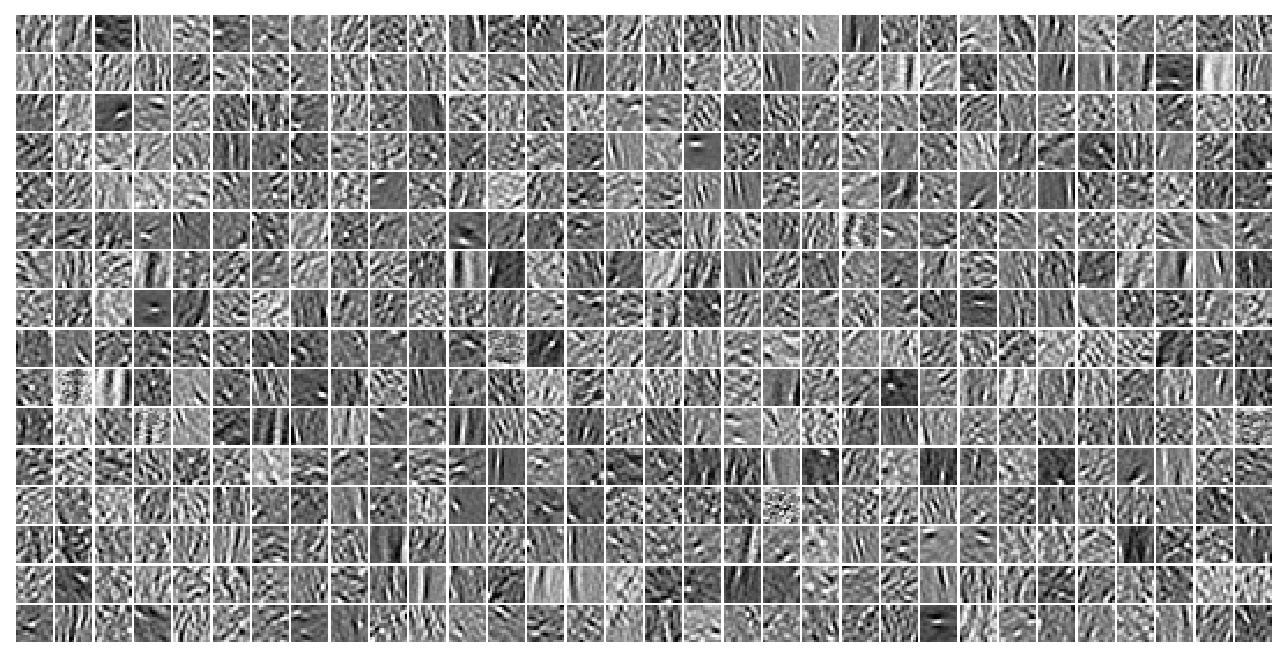

In [7]:
tr.model.show();

<Axes: ylabel='Count'>

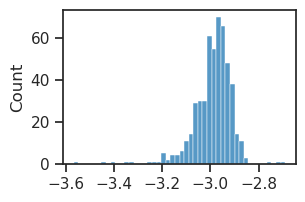

In [9]:
u_prior = tonp(vae.log_rate.squeeze())
sns.histplot(u_prior)

In [3]:
fc_enc = nn.Linear(in_features=256, out_features=512)
fc_dec = nn.Linear(in_features=512, out_features=256)

print(fc_enc.weight.shape, fc_dec.weight.shape)

torch.Size([512, 256])
torch.Size([256, 512])

## HIP-VAE

In [5]:
print(vae)

HIPVAE(
  (mse): MSELoss()
  (layers): ModuleDict(
    (L_0): PoissonLayer(dim=512, input_dim=256, temp=1, n_exp=263)
  )
)

In [6]:
print(vae.layers['L_0'])

PoissonLayer(dim=512, input_dim=256, temp=1, n_exp=263)

In [7]:
seq_len = 4

x = torch.randn(1000, 1, 256).to(device)
x = x.expand(-1, seq_len, -1)
x.shape

torch.Size([1000, 4, 256])

In [8]:
%%time

ff, fb, kl, recon = vae(x)

CPU times: user 2.04 s, sys: 64.5 ms, total: 2.11 s
Wall time: 175 ms


In [10]:
list(vae.layers.values())[-1].phi.shape

torch.Size([256, 512])

In [16]:
fb['T_0']['L_0'].shape

torch.Size([1000, 256])

In [17]:
kl['T_0']['L_0'].shape, recon['T_0'].shape

(torch.Size([1000, 512]), torch.Size([1000]))

In [18]:
list(ff)

['T_0', 'T_1', 'T_2', 'T_3']

In [19]:
fb['T_0']['L_0'].shape, ff['T_0']['L_0'].shape

(torch.Size([1000, 256]), torch.Size([1000, 512]))

In [20]:
z = torch.randn(123, 512)
phi = vae.layers['L_0'].phi
proj = vae.layers['L_0'].proj
z.shape, phi.shape, proj.shape

(torch.Size([123, 512]), torch.Size([256, 512]), torch.Size([512, 256]))

In [21]:
res = F.linear(z, phi)
res.shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:1! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [4]:
from vae.layers import PoissonLayer

pl = PoissonLayer(cfg)
print_num_params(pl)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  262.7 K   |
|     ---      |    ---     |
+--------------+------------+

In [5]:
pl.phi.shape, pl.proj.shape, pl.log_rate.shape

(torch.Size([256, 512]), torch.Size([512, 256]), torch.Size([1, 512]))

In [6]:
print(pl)

PoissonLayer(dim_internal=512, dim_external=256)

In [9]:
pl = PoissonLayer(cfg)
print(pl)

PoissonLayer()

In [ ]:
def __repr__(self):
    main_info = ', '.join([
        f"PoissonLayer(dim_internal={self.dim_internal}",
        f"dim_external={self.dim_external}",
        f"prior_log_dist={self.prior_log_dist})",
    ])
    param_info = '\n\t'.join([
        f"phi: {tuple(self.phi.shape)}",
        f"proj: {tuple(self.proj.shape)}",
        f"log_rate: {tuple(self.log_rate.shape)}"
    ])
    return f"{main}\n{param_info}"

In [46]:
def f(x, log=False):
    if log:
        return 1 + np.exp(x) * (x - 1)
    else:
        return 1 + x * (np.log(x) - 1)

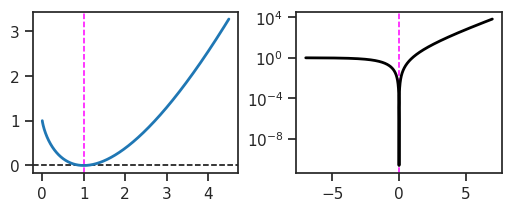

In [60]:
fig, axes = create_figure(1, 2, (5, 2))
axes[0].axhline(0, color='k', ls='--', lw=1.1)
axes[0].axvline(1, color='magenta', ls='--', lw=1.1)
axes[1].axvline(0, color='magenta', ls='--', lw=1.1)

xs = np.linspace(0, 4.5, 1000000)[1:]
axes[0].plot(xs, f(xs, False), color='C0', lw=2)
axes[0].locator_params(axis='x', nbins=6)

xs = np.linspace(-7, 7, 1000000)
axes[1].plot(xs, f(xs, True), color='k', lw=2, alpha=1.0)
axes[1].set_yscale('log')

plt.show()

In [123]:
z = torch.randn(123, 512, device=device)
w = torch.randn(512, 256, device=device)

In [124]:
x_hat = z @ w
x_hat.shape

torch.Size([123, 256])

In [126]:
x_hat = F.linear(z, w.T)
x_hat.shape

torch.Size([123, 256])

In [127]:
def f_at():
    return z @ w


def f_linear():
    return F.linear(z, w.T)

In [129]:
%timeit f_at

8.46 ns ± 1.28 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [130]:
%timeit f_linear

7.71 ns ± 0.00706 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [132]:
%timeit f_at

7.71 ns ± 0.0102 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [131]:
%timeit f_linear

8.24 ns ± 1.22 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [134]:
z = torch.randn(123, 512)
w = torch.randn(512, 256)
w = F.normalize(w, dim=-1)
# w /= torch.linalg.vector_norm(w, ord=2, dim=-1, keepdim=True)
w = nn.Parameter(w, requires_grad=True)

In [137]:
torch.linalg.vector_norm(w, ord=2, dim=-1).shape

torch.Size([512])

In [142]:
def matrix_norm():
    return torch.linalg.matrix_norm(w, ord='nuc')


def svdvals():
    return torch.linalg.svdvals(w).sum()

In [147]:
%timeit matrix_norm

7.75 ns ± 0.0955 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [148]:
%timeit svdvals

7.71 ns ± 0.0106 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [149]:
%timeit svdvals

7.71 ns ± 0.0107 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [150]:
%timeit matrix_norm

7.71 ns ± 0.00935 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [99]:
a = torch.eye(5)
a[1] = a[0]
a[2] = a[0]
# a[3] = a[0]
# a[4] = a[0]

a /= torch.linalg.matrix_norm(a, ord=2)

torch.linalg.matrix_norm(a, ord='nuc')

tensor(2.1547)

In [100]:
u, s, v = torch.linalg.svd(a)
s.sum(), s

(tensor(2.1547), tensor([1.0000, 0.5774, 0.5774, 0.0000, 0.0000]))

In [181]:
w = torch.randn(512, 256)
w = F.normalize(w, dim=-1)
w = nn.Parameter(w, requires_grad=True)

w.shape, torch.linalg.matrix_rank(w)

(torch.Size([512, 256]), tensor(256))

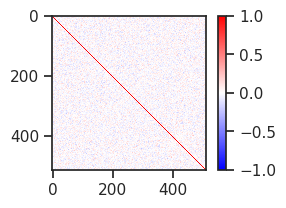

In [182]:
a = w @ w.T

plt.imshow(tonp(a), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [183]:
w = torch.randn(512, 16) @ torch.randn(16, 256)
w = F.normalize(w, dim=-1)
w = nn.Parameter(w, requires_grad=True)

w.shape, torch.linalg.matrix_rank(w)

(torch.Size([512, 256]), tensor(16))

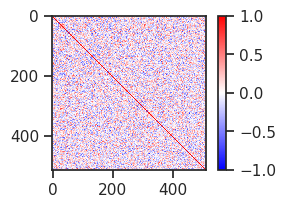

In [184]:
a = w @ w.T

plt.imshow(tonp(a), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

## Fit

In [55]:
w = torch.randn(512, 8) @ torch.randn(8, 256)
# w = F.normalize(w, dim=-1)
w = nn.Parameter(w, requires_grad=True)

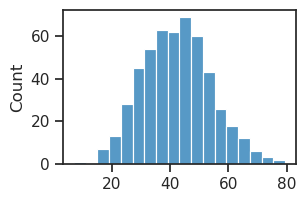

In [56]:
norms_start = tonp(torch.linalg.vector_norm(w, dim=-1))
sns.histplot(norms_start);

In [57]:
w

Parameter containing:
tensor([[-4.2527, -2.5341,  1.8932,  ..., -1.4140, -3.3808, -1.7558],
        [ 4.3097, -1.3758, -1.7783,  ...,  3.1838,  2.4993,  4.9843],
        [ 2.4794, -4.9898,  1.0499,  ...,  1.6520, -9.9489, -1.5588],
        ...,
        [-0.4870, -3.9585, -1.1667,  ..., -0.7477, -3.9441, -0.4928],
        [ 2.0807, -0.3368,  3.9922,  ...,  4.9439, -3.6622, 10.9744],
        [-1.9074,  4.6716,  3.8485,  ..., -0.3051, -3.3417,  4.3179]],
       requires_grad=True)

In [58]:
optim = torch.optim.Adam(
    params=[w],
    lr=3e-4,
)

In [59]:
ranks = []
for i in range(15):
    w_normed = F.normalize(w, dim=-1)
    with torch.inference_mode():
        ranks.append(torch.linalg.matrix_rank(
            w_normed).item())
    loss = torch.linalg.matrix_norm(
        w_normed, ord='nuc').mul(-1.0)
    optim.zero_grad()
    loss.backward()
    optim.step()

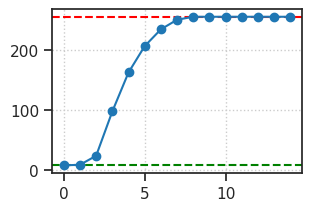

In [60]:
fig, ax = create_figure()

ax.axhline(8, color='g', ls='--')
ax.axhline(256, color='r', ls='--')
ax.plot(ranks, marker='o')
ax.grid()
plt.show()

In [61]:
torch.linalg.matrix_rank(w), torch.linalg.matrix_rank(F.normalize(w, dim=-1))

(tensor(256), tensor(256))

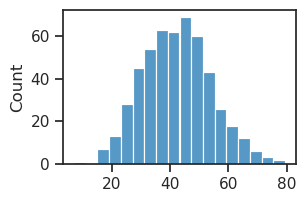

In [62]:
norms_end = tonp(torch.linalg.vector_norm(w, dim=-1))
sns.histplot(norms_end);

In [63]:
sp_stats.pearsonr(norms_start, norms_end)

PearsonRResult(statistic=0.9999999787382738, pvalue=0.0)

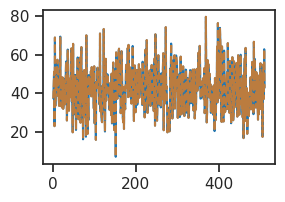

In [64]:
plt.plot(norms_start)
plt.plot(norms_end, ls='--', alpha=0.7);